# Parameters

In [1]:
source_folder = '../Data_En/pdata'
destination_folder = './model_bert_en'

# Libraries

In [13]:
# Libraries
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2"
import matplotlib.pyplot as plt
import pandas as pd
import torch
import numpy as np
# Preliminaries

from torchtext.legacy.data import LabelField, Field, TabularDataset, BucketIterator, Iterator

# Models

import torch.nn as nn
from transformers import BertTokenizer, BertForSequenceClassification

# Training

import torch.optim as optim

# Evaluation

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

# Preliminaries

In [3]:
import spacy
spacy_en = spacy.load('en_core_web_sm')

# create a tokenizer function
def tokenizer(text): 
    return [tok.text for tok in spacy_en.tokenizer(text)]

In [4]:
# Model parameter
MAX_SEQ_LEN = 128
device = 'cpu'
EMBEDDING_SIZE = 200
SENTENCE_LIMIT_SIZE = 200
LEARNING_RATE = 1e-3
# Fields
TEXT = Field(tokenize=tokenizer, lower=True, fix_length=128, batch_first=True)       #以空格分开，小写，fix_length指定了每条文本的长度，截断补长
LABEL = LabelField(dtype=torch.float)

fields = [('label', LABEL), ('title', TEXT), ('text', TEXT), ('titletext', TEXT)]

In [5]:


# TabularDataset

train, valid, test = TabularDataset.splits(path=source_folder, train='train.csv', validation='valid.csv',
                                           test='test.csv', format='CSV', fields=fields, skip_header=True)



In [6]:
print(train[0].titletext)
print(train[0].__dict__.keys())

['obamacare', "'s", 'unlikely', 'no', '.', '1', 'city', '.', 'killing', 'obama', 'administration', 'rules', ',', 'dismantling', 'obamacare', 'and', 'pushing', 'through', 'tax', 'reform', 'are', 'on', 'the', 'early', 'to', '-', 'do', 'list', '.']
dict_keys(['label', 'title', 'text', 'titletext'])


In [7]:
#创建vocab
TEXT.build_vocab(train, max_size=10000, vectors='glove.6B.200d')
LABEL.build_vocab(train)
print(len(TEXT.vocab))                     #10002
print(TEXT.vocab.itos[:12])                #['<unk>', '<pad>', 'the', ',', 'a', 'and', 'of', 'to', '.', 'is', 'in', 'that']
print(TEXT.vocab.stoi['like'])             #32
print(LABEL.vocab.stoi)                    #defaultdict(None, {0: 0, 1: 1})

10002
['<unk>', '<pad>', 'the', ',', '.', 'to', 'of', 'and', 'a', 'in', 'that', 'is']
102
defaultdict(None, {'0': 0, '1': 1})


In [8]:
# Iterators

train_iter = BucketIterator(train, batch_size=16, sort_key=lambda x: len(x.text),
                            device=device, train=True, sort=True, sort_within_batch=True)
valid_iter = BucketIterator(valid, batch_size=16, sort_key=lambda x: len(x.text),
                            device=device, train=True, sort=True, sort_within_batch=True)
test_iter = Iterator(test, batch_size=16, device=device, train=False, shuffle=False, sort=False)

# Model

In [9]:
class TextCNN(nn.Module):   
    def __init__(self, vocab_size, embedding_dim, output_size, filter_num=100, kernel_lst=(3,4,5), dropout=0.5):
        super(TextCNN, self).__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.convs = nn.ModuleList([
                             nn.Sequential(nn.Conv2d(1, filter_num, (kernel, embedding_dim)),
                                            nn.ReLU(),
                                            nn.MaxPool2d((MAX_SEQ_LEN - kernel + 1, 1)))
                              for kernel in kernel_lst])
        self.fc = nn.Linear(filter_num * len(kernel_lst), output_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.embedding(x)       #(batch, word_num, embedding_dim)
        x = x.unsqueeze(1)          #[128, 1, 20, 200] 即(batch, channel_num, word_num, embedding_dim)
        out = [conv(x) for conv in self.convs]

        out = torch.cat(out, dim=1)      # [128, 300, 1, 1]
        out = out.view(x.size(0), -1)    #[128, 300]
        out = self.dropout(out)
        logit = self.fc(out)             #[128, 2]

        return logit




In [10]:
UNK_IDX = TEXT.vocab.stoi[TEXT.unk_token]
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]

In [11]:
#使用预训练过的embedding来替换随机初始化
cnn = TextCNN(len(TEXT.vocab), 200, 2)

pretrained_embedding = TEXT.vocab.vectors                          #torch.Size([10002, 200])
cnn.embedding.weight.data.copy_(pretrained_embedding)
cnn.embedding.weight.data[UNK_IDX] = torch.zeros(EMBEDDING_SIZE)
cnn.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_SIZE)


optimizer = optim.Adam(cnn.parameters(), lr=LEARNING_RATE, weight_decay = 0.01)
criteon = nn.CrossEntropyLoss()


#计算准确率
def binary_acc(preds, y):

    correct = torch.eq(preds, y).float() 
    acc = correct.sum() / len(correct)
    return acc


#训练函数
def train(cnn, iterator, optimizer, criteon):
    avg_acc = []
    cnn.train()        #表示进入训练模式

    for i, batch in enumerate(iterator):
        pred = cnn(batch.text)                         #torch.Size([128, 2])
        loss = criteon(pred, batch.label.long())       #不加.long()会报错


        acc = binary_acc(torch.max(pred, dim=1)[1], batch.label)   #计算每个batch的准确率
        avg_acc.append(acc)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    avg_acc = np.array(avg_acc).mean()
    return avg_acc



#评估函数
def evaluate(cnn, iterator, criteon):
    avg_acc = []
    cnn.eval()         #表示进入测试模式

    with torch.no_grad():
        for i, batch in enumerate(iterator):
            pred = cnn(batch.text)               #torch.Size([128, 2])
            acc = binary_acc(torch.max(pred, dim=1)[1], batch.label)
            avg_acc.append(acc)

    avg_acc = np.array(avg_acc).mean()
    return avg_acc





In [14]:
cnn_train_acc, cnn_test_acc = [], []

for epoch in range(50):

    train_acc = train(cnn, train_iter, optimizer, criteon)
    print('epoch={},训练准确率={}'.format(epoch, train_acc))

    test_acc = evaluate(cnn, test_iter, criteon)
    print("epoch={},测试准确率={}".format(epoch, test_acc))
    # TO DO 自动保存
    cnn_train_acc.append(train_acc)
    cnn_test_acc.append(test_acc)


epoch=0,训练准确率=0.841796875
epoch=0,测试准确率=0.8321595788002014
epoch=1,训练准确率=0.8828125
epoch=1,测试准确率=0.8461854457855225
epoch=2,训练准确率=0.955078125
epoch=2,测试准确率=0.8493545055389404
epoch=3,训练准确率=0.974609375
epoch=3,测试准确率=0.8460094332695007
epoch=4,训练准确率=0.96484375
epoch=4,测试准确率=0.8516432046890259
epoch=5,训练准确率=0.98046875
epoch=5,测试准确率=0.8486502766609192
epoch=6,训练准确率=0.990234375
epoch=6,测试准确率=0.8433685898780823
epoch=7,训练准确率=0.98828125
epoch=7,测试准确率=0.8416079878807068
epoch=8,训练准确率=0.98828125
epoch=8,测试准确率=0.8491784334182739
epoch=9,训练准确率=0.99609375
epoch=9,测试准确率=0.8497065901756287
epoch=10,训练准确率=0.998046875
epoch=10,测试准确率=0.846361517906189
epoch=11,训练准确率=0.9921875
epoch=11,测试准确率=0.8414319753646851
epoch=12,训练准确率=0.994140625
epoch=12,测试准确率=0.8477699756622314
epoch=13,训练准确率=0.994140625
epoch=13,测试准确率=0.8510563373565674
epoch=14,训练准确率=0.990234375
epoch=14,测试准确率=0.8529929518699646
epoch=15,训练准确率=0.998046875
epoch=15,测试准确率=0.8503521084785461
epoch=16,训练准确率=0.9921875
epoch=16,测试准确率=0.848063409328

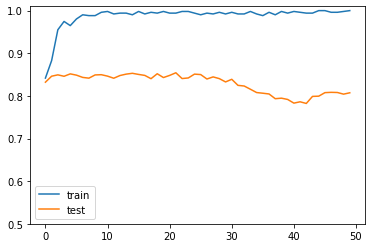

In [16]:

plt.plot(cnn_train_acc)
plt.plot(cnn_test_acc)
plt.ylim(ymin=0.5, ymax=1.01)
plt.legend(["train", "test"])